In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

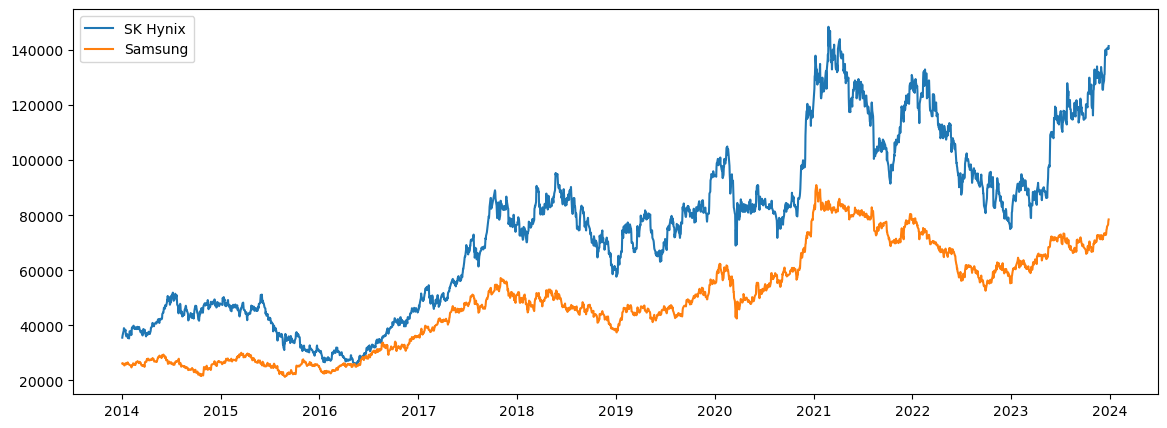

In [11]:
start_date = '2014-01-01'
end_date = '2024-01-01'

# 예시 데이터를 사용하여 SK하이닉스 및 삼성 주가 데이터를 로드합니다.
sk_hynix_data = yf.download('000660.KS', start=start_date, end=end_date, progress=False)
samsung_data = yf.download('005930.KS', start=start_date, end=end_date, progress=False)

sk_hynix_data = sk_hynix_data[['Close']]
samsung_data = samsung_data[['Close']]

# 데이터 시각화
plt.figure(figsize=(14,5))
plt.plot(sk_hynix_data, label='SK Hynix')
plt.plot(samsung_data, label='Samsung')
plt.legend()
plt.show()


In [88]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sk_hynix = scaler.fit_transform(sk_hynix_data)
scaled_samsung = scaler.fit_transform(samsung_data)

# 시계열 데이터셋 생성 함수
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_step-1):
        a = X[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(y[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(scaled_sk_hynix, scaled_samsung, time_step)

# 데이터를 학습 및 테스트 세트로 분리
train_size = int(len(X) * 0.65)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# LSTM 입력 형식에 맞게 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [14]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
epochs = 100

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(torch.FloatTensor(seq))

        single_loss = loss_function(y_pred, torch.FloatTensor([labels]))
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')


Epoch 0 loss: 0.0019754937384277582
Epoch 10 loss: 0.00014449453738052398
Epoch 20 loss: 0.0003052842803299427
Epoch 30 loss: 0.00028891151305288076
Epoch 40 loss: 0.0003409588825888932
Epoch 50 loss: 0.0005366415134631097
Epoch 60 loss: 0.0005070795305073261
Epoch 70 loss: 0.0006286264979280531
Epoch 80 loss: 0.0006431335350498557
Epoch 90 loss: 0.0006773966597393155


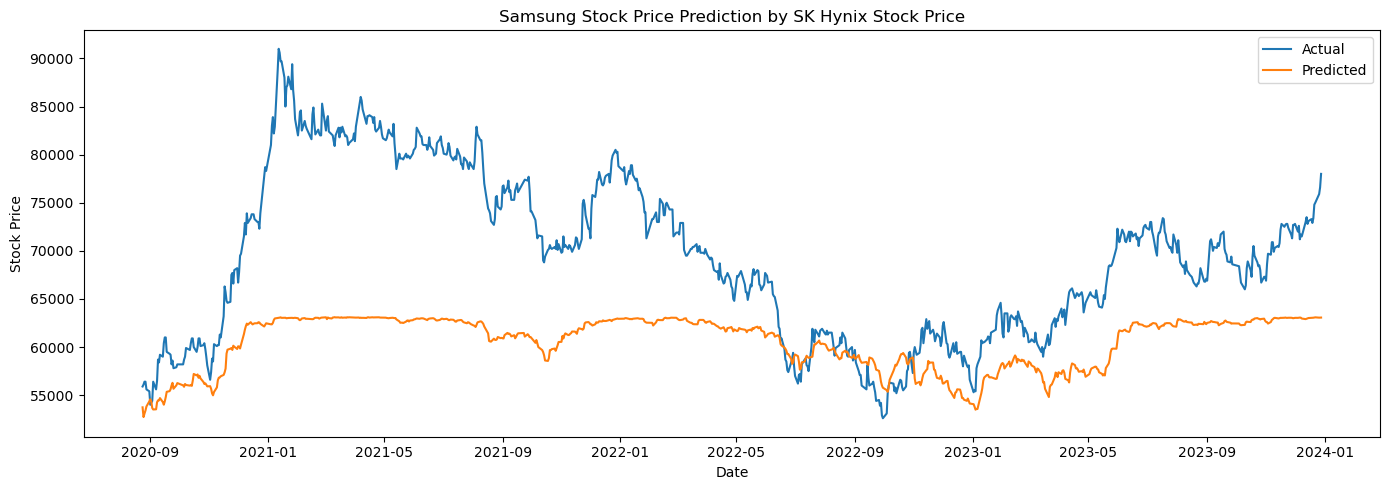

In [98]:
# 모델 예측
model.eval()

test_inputs = X_train[-time_step:].tolist()
predictions = []

for i in range(len(X_test)):
    seq = torch.FloatTensor(test_inputs[-time_step:])
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq.view(-1, 1, 1)).item())
    test_inputs.append(X_test[i].tolist())

# 예측값 역정규화
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

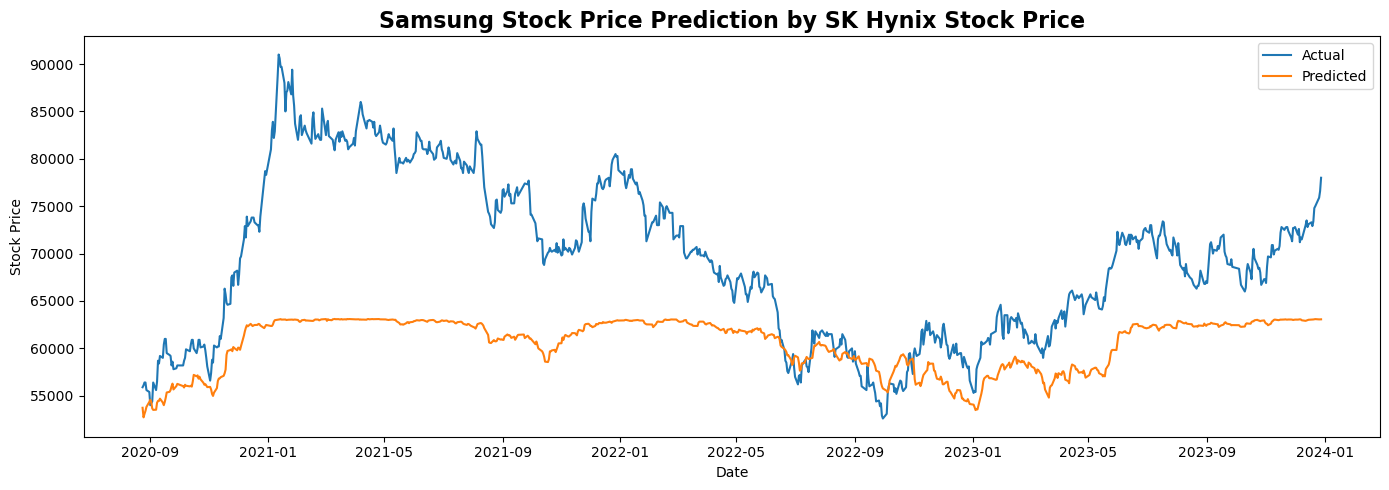

In [102]:
# 실제값과 예측값 비교
plt.figure(figsize=(14,5))
plt.plot(samsung_data.index[len(samsung_data) - len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(samsung_data.index[len(samsung_data) - len(y_test):], predictions, label='Predicted')
plt.title('Samsung Stock Price Prediction by SK Hynix Stock Price', fontdict={'fontweight': 'bold', 'fontsize': 16})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

In [163]:
predictions_df = pd.DataFrame(predictions, index=samsung_data.index[len(samsung_data) - len(y_test):], columns=['Predicted'])
predictions_df['diff'] = predictions_df.diff()
actual_df = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), index=samsung_data.index[len(samsung_data) - len(y_test):], columns=['Actual'])
actual_df['diff'] = actual_df.diff()

predictions_df = predictions_df.drop(predictions_df.index[0])
actual_df = actual_df.drop(actual_df.index[0])
# print(predictions_df.head(2))
# print(actual_df.head(2))

sign = -1
boundary = [[(predictions_df['diff'].index[0], -1)], [(actual_df['diff'].index[0], 1)], []]
for i in range(1,len(predictions_df['diff'])):
    if (predictions_df['diff'].iloc[i] > 0 and sign == -1):
        sign = 1
        boundary[0].append((predictions_df['diff'].index[i], sign))
    elif (predictions_df['diff'].iloc[i] < 0 and sign == 1):
        sign = -1
        boundary[0].append((predictions_df['diff'].index[i], sign))

sign = 1
for i in range(1,len(actual_df['diff'])):
    if (actual_df['diff'].iloc[i] > 0 and sign == -1):
        sign = 1
        boundary[1].append((actual_df['diff'].index[i], sign))
    elif (actual_df['diff'].iloc[i] < 0 and sign == 1):
        sign = -1
        boundary[1].append((actual_df['diff'].index[i], sign))
# print(boundary[0][:10])

for i in range(len(predictions_df['diff'])-1):
    if predictions_df.iloc[i, 1] * actual_df.iloc[i, 1] > 0:
        boundary[2].append((predictions_df.index[i], 1))
    else:
        boundary[2].append((predictions_df.index[i], -1))

# print(boundary[2][:10])



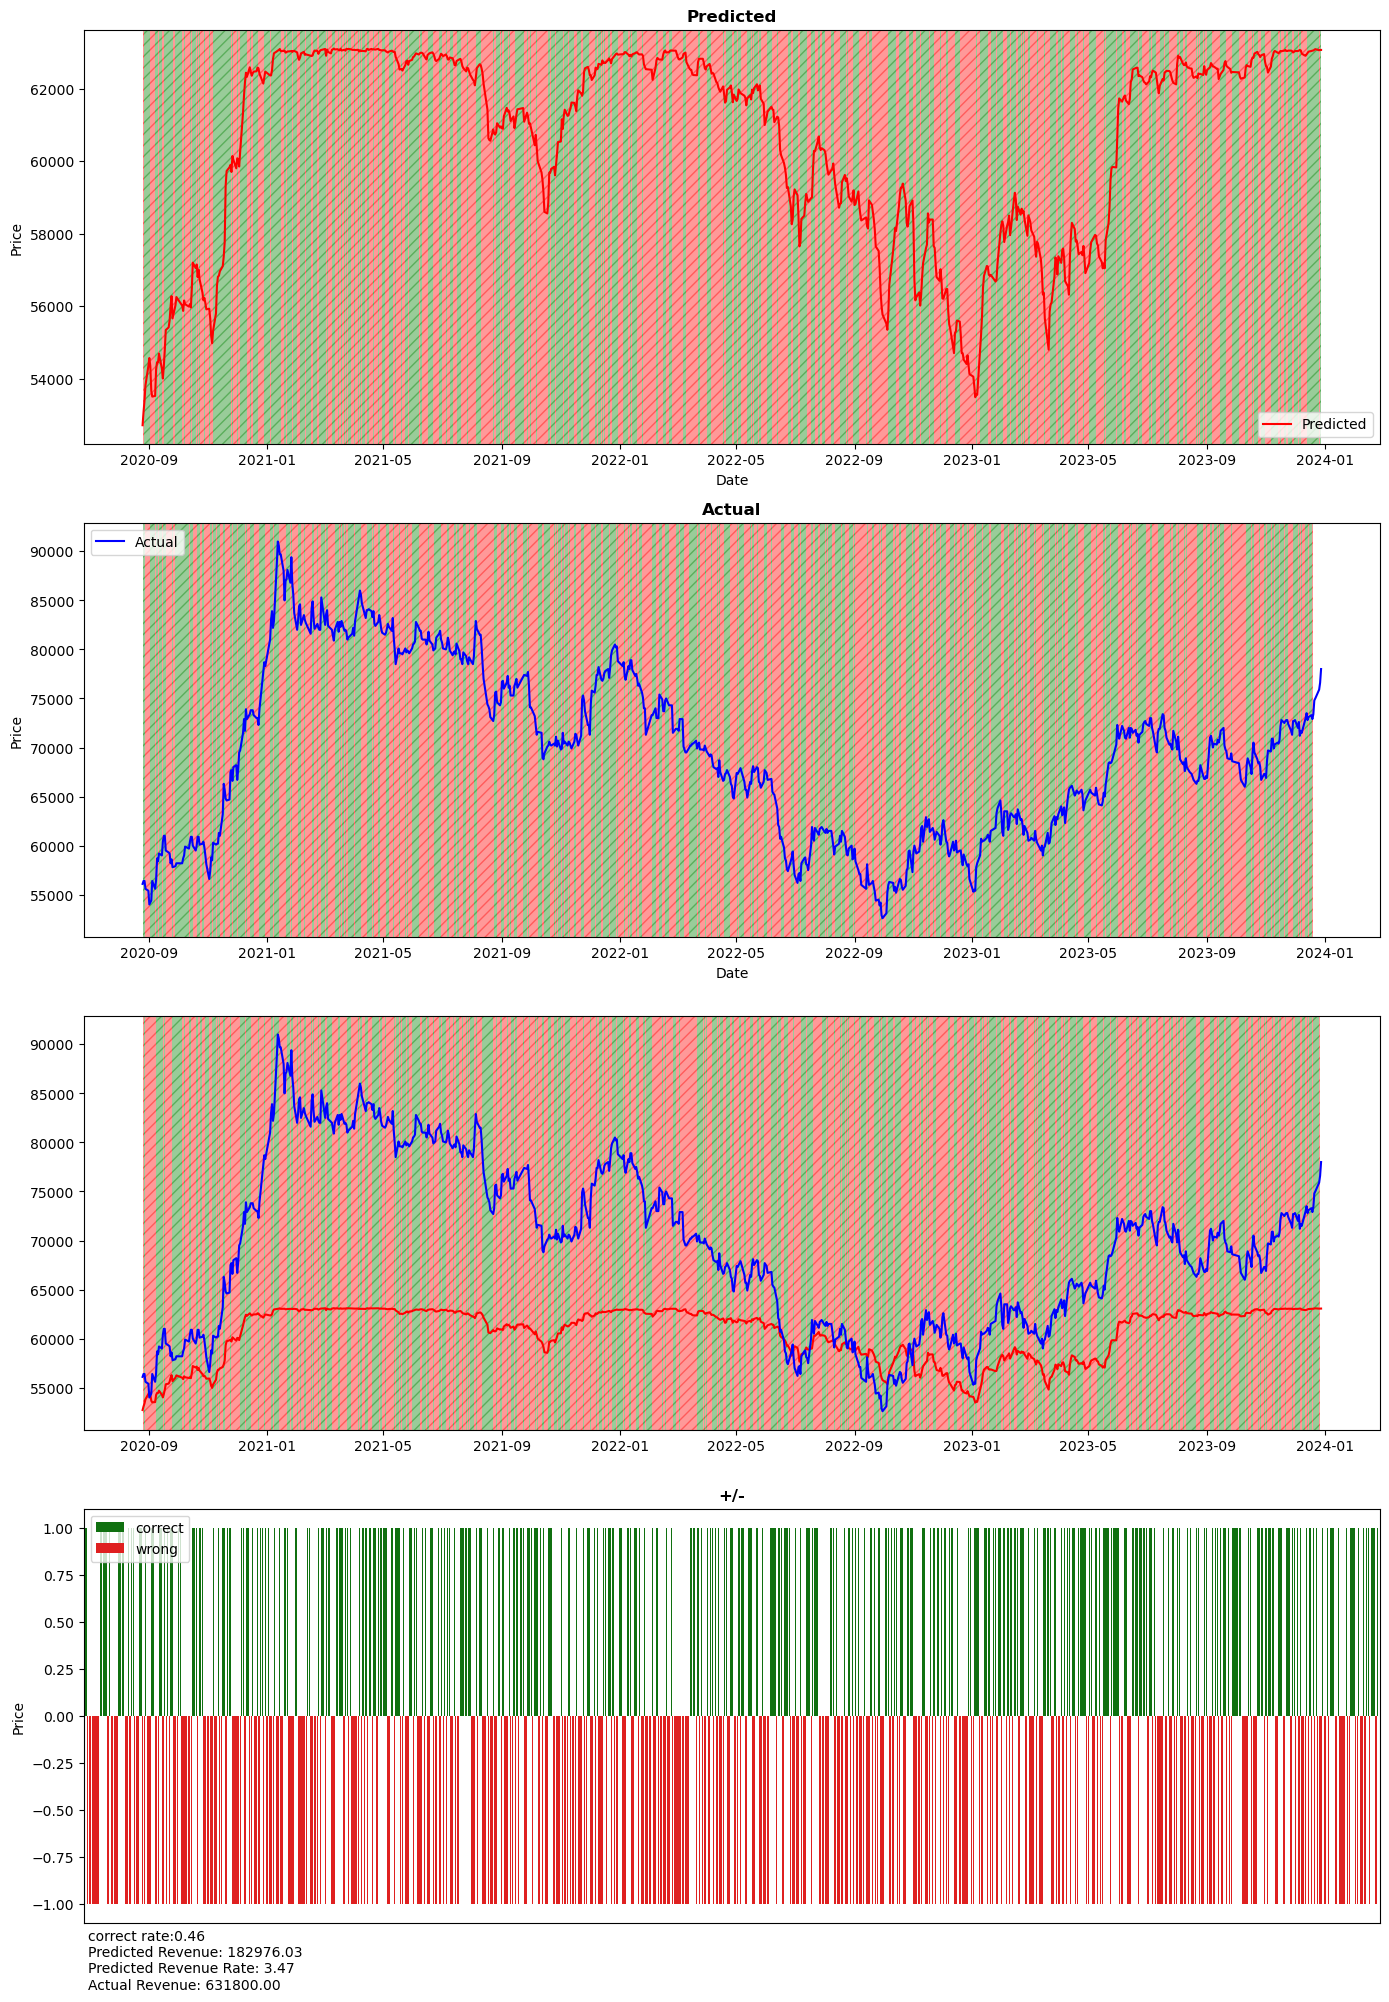

In [196]:
fig, axs = plt.subplots(4,1, figsize=(14,20))
axs[0].plot(predictions_df['Predicted'], label='Predicted', color='r')
for i in range(len(boundary[0])-1):
    if boundary[0][i][1] == 1:
        axs[0].axvspan(boundary[0][i][0], boundary[0][i+1][0], color='g', alpha=0.4, linewidth=0, hatch='///')
    else:
        axs[0].axvspan(boundary[0][i][0], boundary[0][i+1][0], color='r', alpha=0.4, linewidth=0, hatch='///')
axs[0].set_title('Predicted', fontdict={'fontweight': 'bold', 'fontsize': 12})
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(actual_df['Actual'], label='Actual', color='b')
for i in range(len(boundary[1])-1):
    if boundary[1][i][1] == 1:
        axs[1].axvspan(boundary[1][i][0], boundary[1][i+1][0], color='g', alpha=0.4, linewidth=0, hatch='///')
    else:
        axs[1].axvspan(boundary[1][i][0], boundary[1][i+1][0], color='r', alpha=0.4, linewidth=0, hatch='///')
axs[1].set_title('Actual', fontdict={'fontweight': 'bold', 'fontsize': 12})
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(predictions_df['Predicted'], label='Predicted', color='r')
axs[2].plot(actual_df['Actual'], label='Actual', color='b')
for i in range(len(boundary[2])-1):
    if boundary[2][i][1] == 1:
        axs[2].axvspan(boundary[2][i][0], boundary[2][i+1][0], color='g', alpha=0.4, linewidth=0, hatch='///')
    else:
        axs[2].axvspan(boundary[2][i][0], boundary[2][i+1][0], color='r', alpha=0.4, linewidth=0, hatch='///')

check = pd.DataFrame(columns=['correct', 'wrong'], index=predictions_df.index)
cnt = 0
# print(check.head())
for i in range(len(boundary[2])):
    if boundary[2][i][1] == 1:
        check.iloc[i, 0] = 1
        cnt += 1
    else:
        check.iloc[i, 1] = -1

# print(check.head())

predict_revenue = actual_df.iloc[0, 0]
tmp_predict = 0
actual_revenue = actual_df.iloc[0, 0]
tmp_actual = 0

for i in range(1, len(predictions_df)-1):
    if predictions_df.iloc[i, 0] < predictions_df.iloc[i+1, 0] and predictions_df.iloc[i, 1] <= 0:
        predict_revenue -= actual_df.iloc[i, 0]
    elif predictions_df.iloc[i, 0] > predictions_df.iloc[i+1, 0] and predictions_df.iloc[i, 1] >= 0:
        predict_revenue += actual_df.iloc[i, 0]
        tmp_predict = predict_revenue

    if actual_df.iloc[i, 0] < actual_df.iloc[i+1, 0] and actual_df.iloc[i, 1] <= 0:
        actual_revenue -= actual_df.iloc[i, 0]
    elif actual_df.iloc[i, 0] > actual_df.iloc[i+1, 0] and actual_df.iloc[i, 1] >= 0:
        actual_revenue += actual_df.iloc[i, 0]
        tmp_actual = actual_revenue

if predict_revenue < 0:
    predict_revenue = tmp_predict

if actual_revenue < 0:
    actual_revenue = tmp_actual

sns.barplot(check['correct'], label='correct', color='g', ax=axs[3])
sns.barplot(check['wrong'], label='wrong', color='r', ax=axs[3])
axs[3].axes.get_xaxis().set_visible(False)
axs[3].set_title('+/-', fontdict={'fontweight': 'bold', 'fontsize': 12})
axs[3].set_ylabel('Price')
axs[3].text(2, -1.45, f'correct rate:{cnt/len(check):.2f}\nPredicted Revenue: {predict_revenue:.2f}\nPredicted Revenue Rate: {predict_revenue/predictions_df.iloc[0, 0]:.2f}\nActual Revenue: {actual_revenue:.2f}')
axs[3].legend()

plt.tight_layout()
plt.show()